# import packages

In [2]:
# Mount Google drive 
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# Text representation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# ML Algo
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Evaluvation
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

from time import time

In [4]:
import string
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

In [5]:
def plotConfusionMatrixHeatmap(input_df: pd.core.frame.DataFrame, model_name: str, figsize=(20, 18)):
    """
    Return the results of a multiclass classification algorithms as a heatmap
    based on a confusion matrix.        
    """
    # Heatmap of the results
    plt.figure(figsize=figsize)
    sns.heatmap(input_df, annot=True, fmt='d', cmap='Reds')
    plt.ylabel('True', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.title(f'Confusion Matrix - {model_name}', size=14, fontweight='bold')
    plt.show()

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Load Training file

In [7]:
data_path = '/content/drive/MyDrive/Springboard/data/train.csv'

In [8]:
full_df = pd.read_csv(data_path)

In [9]:
full_df.shape

(405735, 4)

In [10]:
full_df.columns

Index(['Unnamed: 0', 'index', 'full_text', 'label'], dtype='object')

In [11]:
full_df.head()

,Unnamed: 0,index,full_text,label
0,0,1,Incorrect information on your report-Informati...,Credit reporting
1,1,2,"Over the past 2 weeks, I have been receiving e...",Debt collection
2,2,3,Pioneer has committed several federal violatio...,Debt collection
3,3,8,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",Credit reporting
4,4,11,Closing your account-Company closed your account,Credit card or prepaid card


In [12]:
full_df.drop(columns=['Unnamed: 0', 'index'], inplace=True)

In [13]:
full_df.columns

Index(['full_text', 'label'], dtype='object')

In [14]:
full_df.head()

,full_text,label
0,Incorrect information on your report-Informati...,Credit reporting
1,"Over the past 2 weeks, I have been receiving e...",Debt collection
2,Pioneer has committed several federal violatio...,Debt collection
3,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",Credit reporting
4,Closing your account-Company closed your account,Credit card or prepaid card


In [15]:
full_df['label'].value_counts()

Credit reporting                 144663
Debt collection                   86653
Mortgage                          49406
Credit card or prepaid card       45740
Loans                             40921
Account service                   29044
Money transfer, VC and Others      9308
Name: label, dtype: int64

In [16]:
# Class distribution
full_df['label'].value_counts()/full_df.shape[0] * 100

Credit reporting                 35.654553
Debt collection                  21.357043
Mortgage                         12.176914
Credit card or prepaid card      11.273368
Loans                            10.085647
Account service                   7.158367
Money transfer, VC and Others     2.294108
Name: label, dtype: float64

In [17]:
df = full_df.sample(frac=0.25)

In [18]:
df.shape

(101434, 2)

In [19]:
df.reset_index(inplace=True)

In [20]:
df.head()

,index,full_text,label
0,19040,Good time of the day! \nIn the beginning in XX...,Account service
1,405413,"This is an attempt to correct my XXXX, EXPERIA...",Credit reporting
2,154519,i have about XXXX credit hard inquiries that...,Credit reporting
3,168569,Harassment at my workplace ' telling my employ...,Debt collection
4,131099,On XX/XX/2020 someone without my authorization...,Loans


In [21]:
df.drop(columns='index', inplace=True)

In [22]:
df['label'].value_counts()

Credit reporting                 36331
Debt collection                  21469
Mortgage                         12230
Credit card or prepaid card      11445
Loans                            10205
Account service                   7371
Money transfer, VC and Others     2383
Name: label, dtype: int64

In [23]:
# Class distribution
df['label'].value_counts()/df.shape[0] * 100

Credit reporting                 35.817379
Debt collection                  21.165487
Mortgage                         12.057101
Credit card or prepaid card      11.283199
Loans                            10.060729
Account service                   7.266794
Money transfer, VC and Others     2.349311
Name: label, dtype: float64

# Pre Processing

In [24]:
def clean_text(doc):
    """
      1. Converting all text into lower case
      2. Removing classified words like xxx
      3. Remove stop words
      4. remove punctuation
      5. remove digits
      6. Wordnet lemmatizer
      7. Custom regex for further cleaning
      """
    # Set stop word as english
    stop_word = set(stopwords.words('english'))
    
    # Tokenize the sentence and make all character lower case
    doc = [x.lower() for x in word_tokenize(doc)]
    
    # Remove classified texts
    doc = [x for x in doc if x.lower() != 'xxxx' and x.lower() != 'xx' 
           and x.lower() != 'xx/xx/xxxx' and x.lower() != 'xxxx/xxxx/xxxx']
    
    # Remove stop words
    doc = [x for x in doc if x not in stop_word]
    
    # Remove Punctuation
    doc = [x for x in doc if x not in string.punctuation]
    
    # Remove Digits
    doc = [x for x in doc if not x.isdigit()]
    
    # Set NLTK Wordnet lemmatizer and lemmatize the sentence
    lemmatizer = WordNetLemmatizer()
    doc = " ".join([lemmatizer.lemmatize(word) for word in doc])

    # Regular expression to remove unwanted chars
    pattern_1 = re.compile(r"(\W)|(\d)")
    pattern_2 = re.compile(r"\s\s+")

    doc = pattern_1.sub(" ", doc)
    doc = pattern_2.sub("", doc)
    
    return doc

In [25]:
df['text_processed'] = df.apply(lambda row : clean_text(row['full_text']), axis = 1)

In [26]:
df.head()

,full_text,label,text_processed
0,Good time of the day! \nIn the beginning in XX...,Account service,good time day beginning mail received offer ci...
1,"This is an attempt to correct my XXXX, EXPERIA...",Credit reporting,attempt correct experian credit report identif...
2,i have about XXXX credit hard inquiries that...,Credit reporting,credit hard inquiry randomly account within we...
3,Harassment at my workplace ' telling my employ...,Debt collection,harassment workplace telling employers urgent ...
4,On XX/XX/2020 someone without my authorization...,Loans,xx xxsomeone without authorization ran credit ...


# Encoding and Modeling

In [27]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [28]:
df['label_id'] = label_encoder.fit_transform(df['label'])

In [29]:
# Put the label category into dict for future use
label_map = df.set_index('label_id').to_dict()['label']
label_map

{0: 'Account service',
 1: 'Credit card or prepaid card',
 2: 'Credit reporting',
 3: 'Debt collection',
 4: 'Loans',
 5: 'Money transfer, VC and Others',
 6: 'Mortgage'}

In [30]:
key_to_label_name = [x[1] for x in sorted(label_map.items())]

In [31]:
df.head()

,full_text,label,text_processed,label_id
0,Good time of the day! \nIn the beginning in XX...,Account service,good time day beginning mail received offer ci...,0
1,"This is an attempt to correct my XXXX, EXPERIA...",Credit reporting,attempt correct experian credit report identif...,2
2,i have about XXXX credit hard inquiries that...,Credit reporting,credit hard inquiry randomly account within we...,2
3,Harassment at my workplace ' telling my employ...,Debt collection,harassment workplace telling employers urgent ...,3
4,On XX/XX/2020 someone without my authorization...,Loans,xx xxsomeone without authorization ran credit ...,4


In [32]:
X = df.text_processed
y = df.label_id

In [33]:
print(X.shape, y.shape)

(101434,) (101434,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [34]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(76075,) (76075,)
(25359,) (25359,)


# Multinimial Naive bayes

In [ ]:
# Parameter values to test
param_grid = {
    'TfIdf__max_features' : [10000, 20000, 30000],
    'TfIdf__ngram_range' : [(1,1),(1,2),(2,2)],
    'TfIdf__use_idf' : [True],
    'MultinomialNB__alpha' : [0.01, 0.02, 0.05]
    }

In [ ]:
# Creating pipeline for Naive Bayes Model
pipeline_mnb = Pipeline(steps = [('TfIdf', TfidfVectorizer()),
                              ('MultinomialNB', MultinomialNB())])

In [ ]:
# Apply pipeline into the Gridserach
grid_search_mnb = GridSearchCV(pipeline_mnb, param_grid, cv=5, verbose=1, n_jobs=10)

In [ ]:
grid_search_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  6.6min
[Parallel(n_jobs=10)]: Done 135 out of 135 | elapsed: 29.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('TfIdf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [ ]:
print(grid_search_mnb.best_params_)

{'MultinomialNB__alpha': 0.05, 'TfIdf__max_features': 30000, 'TfIdf__ngram_range': (1, 2), 'TfIdf__use_idf': True}


In [ ]:
print(grid_search_mnb.best_estimator_)

Pipeline(memory=None,
         steps=[('TfIdf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=30000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('MultinomialNB',
                 MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))],
         verbose=False)


In [ ]:
grid_search_mnb.score(X_test, y_test)

0.8203793524981269

In [ ]:
y_predicted = grid_search_mnb.predict(X_test)

In [ ]:
classification_report_mnb = classification_report(y_test, y_predicted)
print(classification_report_mnb)

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1799
           1       0.75      0.80      0.77      2902
           2       0.86      0.85      0.85      9023
           3       0.82      0.77      0.80      5302
           4       0.75      0.77      0.76      2640
           5       0.82      0.61      0.70       568
           6       0.87      0.93      0.90      3125

    accuracy                           0.82     25359
   macro avg       0.81      0.79      0.80     25359
weighted avg       0.82      0.82      0.82     25359



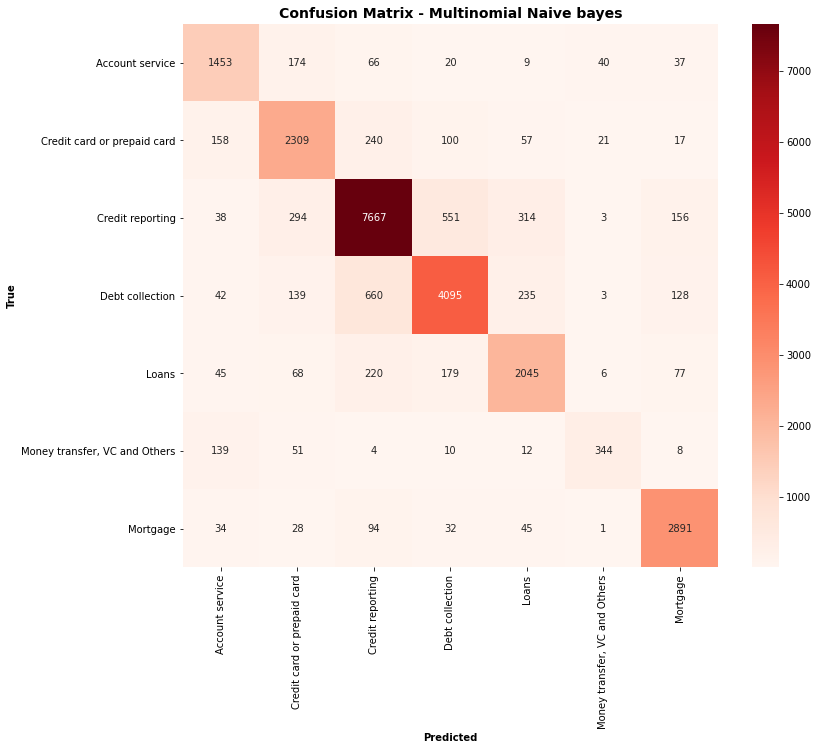

In [ ]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Multinomial Naive bayes', figsize=(12, 10))

## Save the model

In [ ]:
import joblib

In [ ]:
joblib.dump(grid_search_mnb.best_estimator_, 'drive/MyDrive/Springboard/data/models/multinomial_naive_bayes_v3.pkl', compress = 1)

['drive/MyDrive/Springboard/data/models/multinomial_naive_bayes_v3.pkl']

# Logistic Regression

In [ ]:
param_grid_lr = {
    'TfIdf__max_features' : [10000, 20000, 30000],
    'TfIdf__ngram_range' : [(1,1),(1,2),(2,2)],
    'TfIdf__use_idf' : [True]
    }

In [ ]:
# Creating pipeline for Logistice Regression model
pipeline_lr = Pipeline(steps = [('TfIdf', TfidfVectorizer()),
                              ('LogisticRegression', LogisticRegression(class_weight="balanced"))])

In [ ]:
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, verbose=1, n_jobs=10)

In [ ]:
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed: 19.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('TfIdf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [ ]:
print(grid_search_lr.best_params_)

{'TfIdf__max_features': 30000, 'TfIdf__ngram_range': (1, 2), 'TfIdf__use_idf': True}


In [ ]:
print(grid_search_lr.best_estimator_)

Pipeline(memory=None,
         steps=[('TfIdf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=30000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('LogisticRegression',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=T

In [ ]:
grid_search_lr.score(X_test, y_test)

0.8280294964312472

In [ ]:
y_predicted = grid_search_lr.predict(X_test)

In [ ]:
classification_report_lr = classification_report(y_test, y_predicted)
print(classification_report_lr)

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1799
           1       0.77      0.82      0.79      2902
           2       0.90      0.81      0.85      9023
           3       0.81      0.82      0.82      5302
           4       0.73      0.83      0.78      2640
           5       0.64      0.77      0.70       568
           6       0.90      0.92      0.91      3125

    accuracy                           0.83     25359
   macro avg       0.79      0.83      0.80     25359
weighted avg       0.83      0.83      0.83     25359



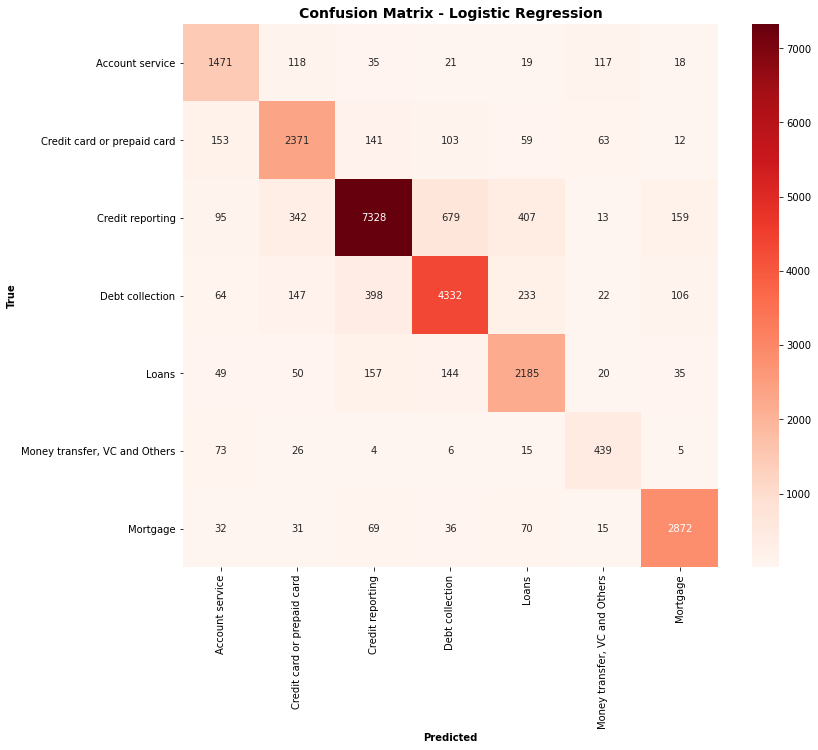

In [ ]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Logistic Regression', figsize=(12, 10))

In [ ]:
joblib.dump(grid_search_lr.best_estimator_, 'drive/MyDrive/Springboard/data/models/logistic_regression_v3.pkl', compress = 1)

['drive/MyDrive/Springboard/data/models/logistic_regression_v3.pkl']

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = TfidfVectorizer(min_df=3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))

In [ ]:
pipeline_rf = Pipeline(steps = [('countvectorizer', vectorizer),
                              ('clf', RandomForestClassifier())])

In [ ]:
model = pipeline_rf.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred_prob = model.predict_proba(X_test)

In [ ]:
lr_probs = y_pred_prob[:,1]

In [ ]:
accuracy_score(y_test, y_pred)

0.7976655230884498

In [ ]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_pred),index=key_to_label_name,
                              columns=key_to_label_name)

In [ ]:
classification_rep = classification_report(y_test, y_pred,target_names=key_to_label_name)
print(classification_rep)

                               precision    recall  f1-score   support

              Account service       0.77      0.76      0.76      1799
  Credit card or prepaid card       0.79      0.71      0.75      2902
             Credit reporting       0.77      0.92      0.84      9023
              Debt collection       0.79      0.76      0.78      5302
                        Loans       0.86      0.60      0.70      2640
Money transfer, VC and Others       0.90      0.26      0.40       568
                     Mortgage       0.89      0.86      0.88      3125

                     accuracy                           0.80     25359
                    macro avg       0.82      0.70      0.73     25359
                 weighted avg       0.80      0.80      0.79     25359



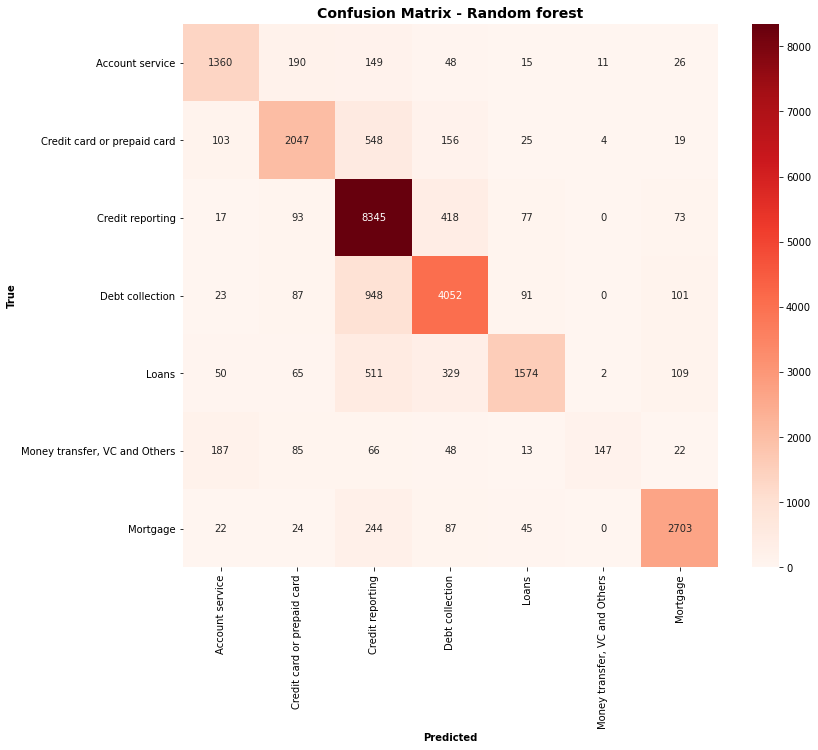

In [ ]:
plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Random forest', figsize=(12, 10))

In [ ]:
joblib.dump(model, 'drive/MyDrive/Springboard/data/models/random_forest_v3.pkl', compress = 1)

['drive/MyDrive/Springboard/data/models/random_forest_v3.pkl']

# Doc2Vec with Logistic Regression

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
#prepare training data in doc2vec format:
train_doc2vec = [TaggedDocument((d), tags=[str(i)]) for i, d in enumerate(X_train)]

In [ ]:
#Train a doc2vec model to learn
model = Doc2Vec(vector_size=50, alpha=0.025, min_count=5, dm =1, epochs=100)
model.build_vocab(train_doc2vec)
model.train(train_doc2vec, total_examples=model.corpus_count, epochs=model.epochs)
model.save("drive/MyDrive/Springboard/data/models/d2v-v3.model")
print("Model Saved")

Model Saved


In [ ]:
#Infer the feature representation for training and test data using the trained model
model= Doc2Vec.load("drive/MyDrive/Springboard/data/models/d2v-v3.model")

In [ ]:
#infer in multiple steps to get a stable representation. 
train_vectors =  [model.infer_vector(list_of_tokens, steps=50) for list_of_tokens in X_train]
test_vectors = [model.infer_vector(list_of_tokens, steps=50) for list_of_tokens in X_test]

In [ ]:
clf = LogisticRegression(class_weight="balanced")
clf.fit(train_vectors, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds = clf.predict(test_vectors)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.40      0.50      0.44      1799
           1       0.39      0.40      0.40      2902
           2       0.75      0.58      0.66      9023
           3       0.54      0.48      0.51      5302
           4       0.37      0.41      0.39      2640
           5       0.11      0.40      0.17       568
           6       0.48      0.53      0.51      3125

    accuracy                           0.51     25359
   macro avg       0.44      0.47      0.44     25359
weighted avg       0.55      0.51      0.52     25359



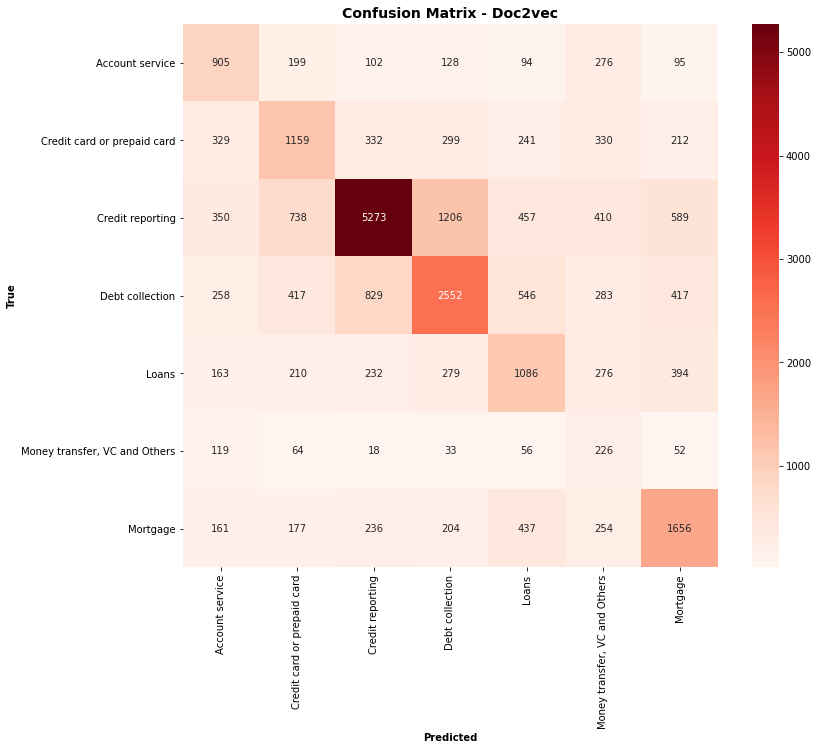

In [ ]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, preds),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Doc2vec', figsize=(12, 10))

In [ ]:
joblib.dump(clf, 'drive/MyDrive/Springboard/data/models/logistic_doc2vec_v3.pkl', compress = 1)

['drive/MyDrive/Springboard/data/models/logistic_doc2vec_v3.pkl']

# Deep Learning

In [34]:
# Necessary Imports
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant

In [35]:
# Download GloVe word embedding
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-01-24 12:58:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-24 12:58:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-24 12:58:15--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [36]:
# Unzip it
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [37]:
!pwd

/content


In [38]:
glove_dir = 'glove'

In [39]:
max_sequence_length = 1000
max_num_words = 20000
embedding_dim = 200
validation_split = 0.2

In [41]:
# Vectorize the text sample into 2D integer tensor using keras Tokenizer
# Tokenizer will fir only on training data and transform both train and test data

tokenizer = Tokenizer(num_words=max_num_words)

tokenizer.fit_on_texts(X.to_list())

train_sequence = tokenizer.texts_to_sequences(X.to_list())

word_index = tokenizer.word_index

In [42]:
print(len(train_sequence[0]))

114


In [43]:
# Converting this to sequences to be fed into neural network. Max seq. len is 1000 as set earlier
# initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH

# Pad_squences is ot make all the samples in same length.
# Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long. 
# Sequences longer than num_timesteps are truncated so that they fit the desired length.

train_valid_data = pad_sequences(train_sequence, maxlen=max_sequence_length)
train_valid_labels = to_categorical(np.asarray(y.to_list()))

In [44]:
print(train_valid_data.shape)

(101434, 1000)


In [45]:
# spliting trainig set and validation set
indices = np.arange(train_valid_data.shape[0]) # Return evenly spaced values within a given interval.
np.random.shuffle(indices) # Modify a sequence in-place by shuffling its contents.

train_valid_data = train_valid_data[indices]
train_valid_labels = train_valid_labels[indices]

In [46]:
num_validation_samples = int(validation_split * train_valid_data.shape[0])

print(num_validation_samples)

20286


In [47]:
X_train = train_valid_data[:-num_validation_samples]
y_train = train_valid_labels[:-num_validation_samples]
X_val = train_valid_data[-num_validation_samples:]
y_val = train_valid_labels[-num_validation_samples:]

In [48]:
# build index mapping words in the embeddings set to their embedding vector
embeddings_index = {}

with open('glove.6B.200d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs


print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))

Found 400000 word vectors in Glove embeddings.


In [49]:
print(embeddings_index["cube"])

[ 0.095789  -0.46755   -0.4109     0.23223    0.52719    0.2036
  0.17575   -0.16305   -0.59678   -0.57058   -0.40217    0.2804
  0.40405    0.2731    -0.36563    0.071209  -0.37869   -0.116
  0.17491    0.27384   -0.74331    0.22654    0.10123   -0.61351
  0.041468   0.29191    0.43205   -0.8113    -0.5454     0.38612
 -0.091256  -0.13519   -0.34071   -0.13824   -0.15446    0.12083
 -0.33084   -1.0632     0.062599   0.11213   -0.53525    0.099355
  0.71156    0.45348   -0.11641    0.68769   -0.45519   -0.25393
  0.0074914  0.28983   -0.009376   0.42163   -0.63396   -0.035484
  0.60248    0.26093   -0.092479   0.15043    0.072953  -0.48143
 -0.57987    0.24628   -0.9747    -0.1702     0.34789   -0.22117
 -0.51841    0.23377    0.51891    0.42052    0.23693    0.26471
  0.18427    0.03566   -0.17597    0.19796    0.69339   -0.37217
 -0.531      0.024534  -0.096397  -0.4331    -0.30723   -1.0936
  0.47536   -0.32422    0.31672    0.70839    0.1111    -0.76518
  0.04056    0.23401   -0.00

In [50]:
# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.

num_words = min(max_num_words, len(word_index)) + 1

embedding_matrix = np.zeros((num_words, embedding_dim)) # Return a new array of given shape and type, filled with zeros.

for word, i in word_index.items():
  if i > max_num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all zeros
    embedding_matrix[i] = embedding_vector

In [51]:
# Loading pre-trained word embedding into an embedding layer

embedding_layer = Embedding(num_words, embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_sequence_length,
                            trainable=False)

In [52]:
label_index = {'Account service' : 0,
               'Credit card or prepaid card' : 1,
               'Credit reporting' : 2,
               'Debt collection':3,
               'Loans':4,
               'Money transfer, VC and Others':5,
               'Mortgage':6}

## CNN Model with pre-trained embedding

In [56]:
cnn = Sequential()
cnn.add(embedding_layer)
cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(MaxPooling1D(5))
cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(MaxPooling1D(5))
cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(len(label_index), activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [57]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 200)         4000200   
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0

In [58]:
#Train the model. Tune to validation set. 
cnn.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
634/634 [==============================] - 855s 1s/step - loss: 0.9675 - acc: 0.6578 - val_loss: 0.5734 - val_acc: 0.8070
Epoch 2/5
634/634 [==============================] - 856s 1s/step - loss: 0.5465 - acc: 0.8182 - val_loss: 0.5590 - val_acc: 0.8115
Epoch 3/5
634/634 [==============================] - 857s 1s/step - loss: 0.4640 - acc: 0.8412 - val_loss: 0.5655 - val_acc: 0.8058
Epoch 4/5
634/634 [==============================] - 856s 1s/step - loss: 0.3990 - acc: 0.8619 - val_loss: 0.5658 - val_acc: 0.8112
Epoch 5/5
634/634 [==============================] - 856s 1s/step - loss: 0.3391 - acc: 0.8799 - val_loss: 0.6062 - val_acc: 0.8080


In [59]:
cnn.save("drive/MyDrive/Springboard/data/models/CNN_model_with_pre_trained_embedding_v3.h5")

## CNN model with training own embedding

In [60]:
print("Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings")
cnnmodel = Sequential()
cnnmodel.add(Embedding(max_num_words, 128))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(len(label_index), activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings


In [61]:
cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)              

In [62]:
#Train the model. Tune to validation set. 
cnnmodel.fit(X_train, y_train,
          batch_size=128,
          epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
634/634 [==============================] - 799s 1s/step - loss: 1.0815 - acc: 0.6019 - val_loss: 0.5286 - val_acc: 0.8223
Epoch 2/5
634/634 [==============================] - 799s 1s/step - loss: 0.4953 - acc: 0.8361 - val_loss: 0.5027 - val_acc: 0.8297
Epoch 3/5
634/634 [==============================] - 797s 1s/step - loss: 0.4260 - acc: 0.8566 - val_loss: 0.4993 - val_acc: 0.8323
Epoch 4/5
634/634 [==============================] - 796s 1s/step - loss: 0.3594 - acc: 0.8768 - val_loss: 0.5080 - val_acc: 0.8308
Epoch 5/5
634/634 [==============================] - 795s 1s/step - loss: 0.2934 - acc: 0.9008 - val_loss: 0.5823 - val_acc: 0.8044


In [63]:
cnnmodel.save("drive/MyDrive/Springboard/data/models/1D_CNN_model_with_training_own_embedding.h5")

In [ ]:
Random Forest Classifier

## CNN Model with pre-trained embedding - Dropout added

In [53]:
cnn2 = Sequential()
cnn2.add(embedding_layer)
cnn2.add(Conv1D(128, 5, activation='relu'))
cnn2.add(MaxPooling1D(5))
cnn2.add(Conv1D(128, 5, activation='relu'))
cnn2.add(MaxPooling1D(5))
cnn2.add(Conv1D(128, 5, activation='relu'))
cnn2.add(GlobalMaxPooling1D())
cnn2.add(Dropout(0.25))
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(len(label_index), activation='softmax'))

cnn2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [54]:
cnn2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 200)         4000200   
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0

In [55]:
#Train the model. Tune to validation set. 
history = cnn2.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_val, y_val))

Epoch 1/3
634/634 [==============================] - 1208s 2s/step - loss: 1.0275 - acc: 0.6340 - val_loss: 0.6031 - val_acc: 0.7939
Epoch 2/3
634/634 [==============================] - 1206s 2s/step - loss: 0.5719 - acc: 0.8117 - val_loss: 0.5471 - val_acc: 0.8160
Epoch 3/3
634/634 [==============================] - 1207s 2s/step - loss: 0.4897 - acc: 0.8367 - val_loss: 0.5582 - val_acc: 0.8127


In [56]:
cnn2.save("drive/MyDrive/Springboard/data/models/CNN_model_with_pre_trained_embedding_dropout_v1.h5")

## CNN model with training own embedding

In [58]:
print("Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings")
cnnmodel2 = Sequential()
cnnmodel2.add(Embedding(max_num_words, 128))
cnnmodel2.add(Conv1D(128, 5, activation='relu'))
cnnmodel2.add(MaxPooling1D(5))
cnnmodel2.add(Conv1D(128, 5, activation='relu'))
cnnmodel2.add(MaxPooling1D(5))
cnnmodel2.add(Conv1D(128, 5, activation='relu'))
cnnmodel2.add(GlobalMaxPooling1D())
cnnmodel2.add(Dense(128, activation='relu'))
cnnmodel2.add(Dense(len(label_index), activation='softmax'))

cnnmodel2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings


In [59]:
cnnmodel2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)              

In [60]:
#Train the model. Tune to validation set. 
cnnmodel2.fit(X_train, y_train,
          batch_size=128,
          epochs=3, validation_data=(X_val, y_val))

Epoch 1/3
634/634 [==============================] - 1154s 2s/step - loss: 1.0250 - acc: 0.6202 - val_loss: 0.5673 - val_acc: 0.8086
Epoch 2/3
634/634 [==============================] - 1154s 2s/step - loss: 0.5044 - acc: 0.8348 - val_loss: 0.5199 - val_acc: 0.8269
Epoch 3/3
634/634 [==============================] - 1148s 2s/step - loss: 0.4222 - acc: 0.8611 - val_loss: 0.5019 - val_acc: 0.8333


In [61]:
cnnmodel2.save("drive/MyDrive/Springboard/data/models/CNN_model_with_training_own_embedding_dropout_v1.h5")

# Test Data

In [62]:
test_data_path = 'drive/MyDrive/Springboard/data/test.csv'

In [63]:
test_data = pd.read_csv(test_data_path)

In [ ]:
test_data.drop(columns=['Unnamed: 0', 'index'], inplace=True)

In [66]:
test_data.head()

,full_text,label,text_processed
0,On a Bank of America credit card ending in XXX...,Credit reporting,bank america credit card ending paid amount du...
1,Equifax mishandled my personal information inc...,Credit reporting,equifax mishandled personal information includ...
2,I already know what SCS is saying. The check i...,Loans,already know sc saying check question bill pay...
3,Under the new law that was effective XXXX XXXX...,Credit reporting,new law effective public record data must incl...
4,Hi i am writing to you today because i had a d...,Loans,hi writing today dispute seems like guy conduc...


In [64]:
 # Process Text
test_data['text_processed'] = test_data.apply(lambda row : clean_text(row['full_text']), axis = 1)

In [68]:
test_data['label_id'] = label_encoder.fit_transform(test_data['label'])

In [69]:
X_test = test_data['text_processed']
y_test = test_data['label_id']

### Multinomial Naive bayes

In [74]:
import joblib

In [75]:
# Loading model to compare the results
model_mnb = joblib.load('drive/MyDrive/Springboard/data/models/multinomial_naive_bayes_v3.pkl')

In [76]:
model_mnb.score(X_test, y_test)

0.8163854479371542

In [77]:
y_predicted = model_mnb.predict(X_test)

In [78]:
classification_report_mnb = classification_report(y_test, y_predicted)
print(classification_report_mnb)

              precision    recall  f1-score   support

           0       0.77      0.81      0.79     12542
           1       0.74      0.80      0.77     19643
           2       0.85      0.84      0.85     62135
           3       0.82      0.77      0.80     36908
           4       0.74      0.77      0.75     17223
           5       0.82      0.60      0.70      4000
           6       0.87      0.93      0.90     21435

    accuracy                           0.82    173886
   macro avg       0.80      0.79      0.79    173886
weighted avg       0.82      0.82      0.82    173886



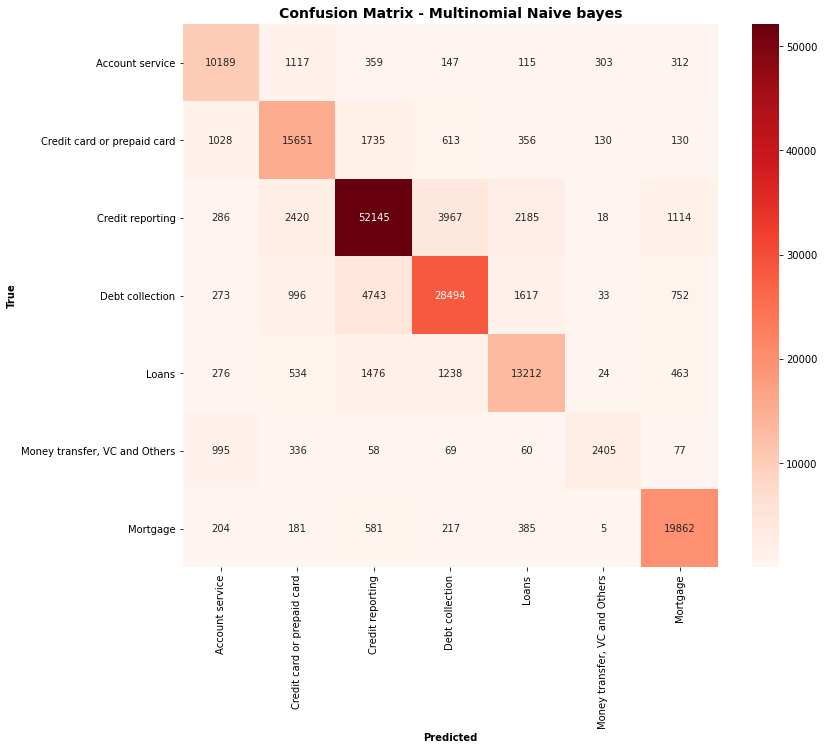

In [79]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Multinomial Naive bayes', figsize=(12, 10))

### Logistic Regression

In [80]:
# Loading model to compare the results
model_lr = joblib.load('drive/MyDrive/Springboard/data/models/logistic_regression_v3.pkl')

In [81]:
model_lr.score(X_test, y_test)

0.8248450133995836

In [82]:
y_predicted = model_lr.predict(X_test)

In [83]:
classification_report_mnb = classification_report(y_test, y_predicted)
print(classification_report_mnb)

              precision    recall  f1-score   support

           0       0.76      0.81      0.78     12542
           1       0.76      0.82      0.79     19643
           2       0.90      0.80      0.85     62135
           3       0.81      0.82      0.81     36908
           4       0.72      0.83      0.77     17223
           5       0.64      0.77      0.70      4000
           6       0.89      0.92      0.91     21435

    accuracy                           0.82    173886
   macro avg       0.78      0.82      0.80    173886
weighted avg       0.83      0.82      0.83    173886



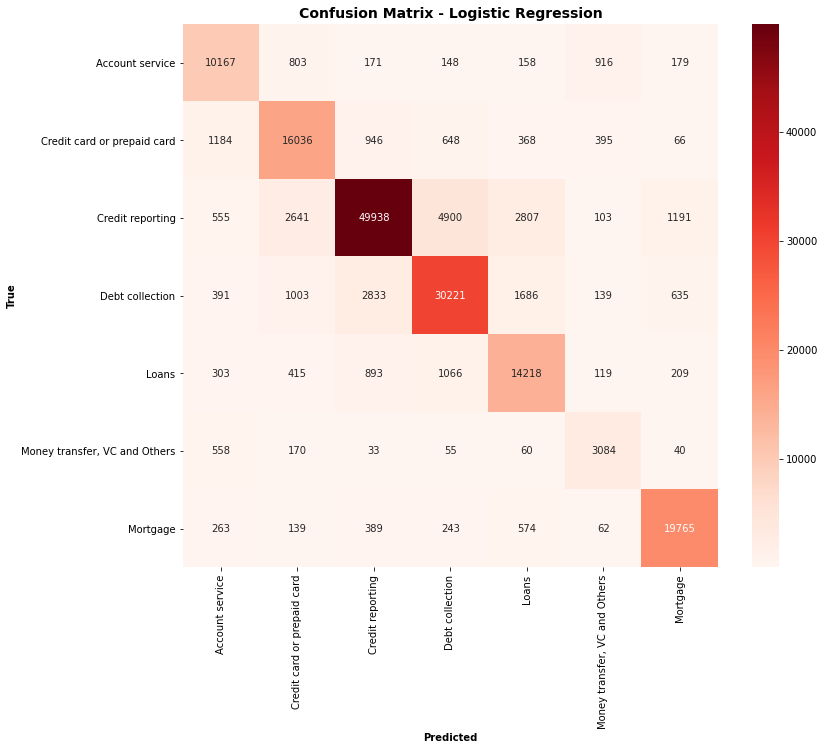

In [84]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Logistic Regression', figsize=(12, 10))

### Random Forest Classifier

In [86]:
# Loading model to compare the results
model_rf = joblib.load('drive/MyDrive/Springboard/data/models/random_forest_v3.pkl')

In [87]:
model_rf.score(X_test, y_test)

0.79714870662388

In [88]:
y_predicted = model_rf.predict(X_test)

In [89]:
classification_report_mnb = classification_report(y_test, y_predicted)
print(classification_report_mnb)

              precision    recall  f1-score   support

           0       0.77      0.74      0.75     12542
           1       0.79      0.70      0.74     19643
           2       0.77      0.92      0.84     62135
           3       0.79      0.76      0.78     36908
           4       0.85      0.60      0.71     17223
           5       0.89      0.27      0.42      4000
           6       0.90      0.87      0.88     21435

    accuracy                           0.80    173886
   macro avg       0.82      0.70      0.73    173886
weighted avg       0.80      0.80      0.79    173886



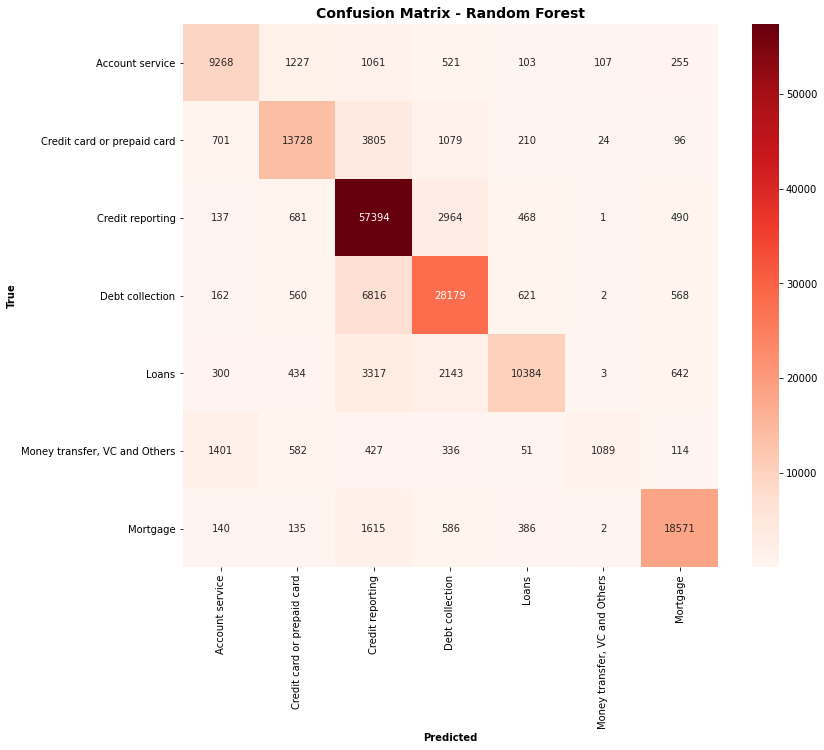

In [90]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Random Forest', figsize=(12, 10))